W tym zadaniu zapoznamy się z pojęciem modeli regresyjnych oraz ich przykładami w Pythonie. Dodatkowo będziemy zajmować się optymalizacją modeli.

Będziemy pracować na danych dotyczących rodzajów fonacji i będziemy analizować dane, które zawierają 13 MFCC oraz ich pierwszą i drugą pochodną wyliczone z sygnałów zawierających samogłoski emitowane przy użyciu dwóch typów fonacji:
1. z nastawieniem miękkim - więzadła głosowe zbliżają się do siebie, a ich przyśrodkowe krawędzie swobodnie drgają
2. z nastawieniem twardym - powstaje przy silnym zwarciu więzadeł głosowych

Rodzaje te są oznaczone odpowiednio labelami 0 i 1.

Źródło danych: https://osf.io/cwquj/

In [28]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, make_scorer, confusion_matrix, log_loss, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import optuna
from sklearn.model_selection import cross_validate, StratifiedKFold
import pickle

In [29]:
#wczytanie danych
X = np.load('padded_feats_binary.npy') #macierz cech - jednej wiersz = jeden obiekt
y = np.load('labels_binary.npy') #labele
print(y)

[0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1
 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0
 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1
 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1
 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1
 0]


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42) #podział na zbiory

In [31]:
scaler = StandardScaler().fit(X_train) #standaryzacja
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Modele regresyjne różnią się od modeli klasyfikacyjnych przede wszystkim tym, co uzyskujemy na wyjściu. Modele klasyfikacyjne (klasyfikatory) zwracają przewidywaną przynależność obiektu do klasy, czyli liczbę całkowitą. Natomiast modele regresyjne (regresory) zwracają wartości ciągłe - może, ale nie musi to być liczba całkowita. Wyniki nie mogą być traktowane bezpośrednio jako przynależność do klas - jeżeli chcemy je do tego wykorzystać, konieczne jest przetworzenie wyników. Jak to zrobić, omówimy w dalszej części zadania.

Pierwszą metodą regresji, której użyjemy jest regresja logistyczna.

Regresja logistyczna prognozuje prawdopodobieństwo wystąpienia zjawiska jako funkcję zmiennych niezależnych. Prawdopodobieństwo to jest opisane funkcją logistyczną, czyli rodzajem funkcji sigmoidalnej - stąd nazwa regresji. W kontekście klasyfikacji można powiedzieć, że regresja logistyczna prognozuje prawdopodobieństwo przynależności obiektu do danej klasy.

In [32]:
lr_reg = LogisticRegression(random_state=42)
lr_reg.fit(X_train_scaled, y_train)
preds_test = lr_reg.predict(X_test_scaled)
preds_train = lr_reg.predict(X_train_scaled)

Z regresją logistyczną związane jest pojęcie straty logarytmicznej (ang. log loss). Oblicza się ją jako ujemną średnią logarytmiczną skorygowanych prawdopodobieństw. Polega to na tym, że otrzymujemy na wyjściu regresora prawdopodobieństwo przynależności obiektu do klasy pozytywnej (1). Prawdopodobieństwo skorygowane oblicza się tak:

- jeżeli obiekt należy do klasy 1, to prawdopodobieństwo skorygowane wynosi tyle, ile wyznaczone przez regresor (pred),

- jeżeli obiekt należy do klasy 0, to prawdopodobieństwo skorygowane wynosi 1-pred.

Ponieważ prawdopodobieństwo przyjmuje wartości z przedziału [0,1], to jego logarytm będzie miał wartość ujemną. Dlatego po policzeniu średniej z logarytmów dodajemy znak '-', żeby uzyskać stratę logarytmiczną o wartości dodatniej. Wtedy im mniejsza strata logarytmiczna, tym predykcje modelu bliższe są wartości rzeczywistej.

In [33]:
print(log_loss(y_test, preds_test))

0.7427779826586198


Dla porównania możemy to policzyć ręcznie zgodnie z algorytmem opisanym powyżej.

In [34]:
corrected_prob = []
for y_pred, y_true in zip(preds_test, y_test):
    if y_true == 0:
        corrected_prob.append(1-y_pred)
    else:
        corrected_prob.append(y_pred)
        
corrected_prob = np.array(corrected_prob)
log_prob = np.log(corrected_prob + 1e-15)
logloss = -(np.mean(log_prob))
print(logloss)

0.742769384836788


Oprócz straty logarytmicznej, do oceny jakości regresora używa się często metryki ROC AUC, czyli pola pod krzywą ROC.

Na początek omówmy, czym jest krzywa ROC i jak wygląda. Krzywa ROC przedstawia zdolności diagnostyczne modelu w zależności od przyjętego progu dyskryminacyjnego. Na osi X jest FPR (1-specyficzność), natomiast na osi Y TPR (czułość). W najlepszym przypadku krzywa ROC powinna rosnąć od 0 do 1 w punkcie x=0, a następnie przebiegać równolegle do osi X. Im bardziej uzyskana krzywa różni się od takiego przebiegu, tym gorszy model.

Teraz narysujemy krzywą ROC uzyskanego modelu. Dodatkowo na wykresie zaznaczymy przypadek oznaczający losowe wyniki zwracane przez model (przerywana niebieska linia).

In [35]:
def plot_roc_curve(y, preds, image_path=None):

    fpr, tpr, thresholds = roc_curve(y, preds)
    # plot the roc curve for the model
    try:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Model')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
#         plt.savefig(image_path, dpi = 300)   # save the figure to file    
    except (IndexError):
        print('Next model')

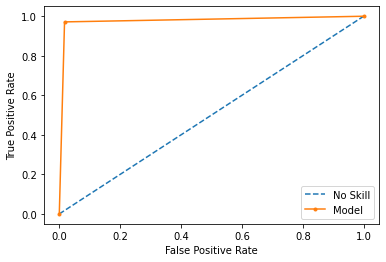

In [36]:
plot_roc_curve(y_test, preds_test, image_path=None)

W indealnym przypadku ROC AUC wynosi 1. Jeżeli wynosi 0.5, to utworzony model regresyjny dokonuje predykcji w sposób losowy (prawdopodobieństwo przynależności do klasy 0 wynosi 0.5, do klasy 1 również 0.5). Taki model nie nadaje się do użytku.

Uzyskanie ROC AUC = 1 jest w przypadku danych rzeczywistych bardzo trudne i nie zawsze jest możliwe. Dążymy jednak do tego, by jego wartość była jak największa.

In [37]:
print('test ROC AUC: ', roc_auc_score(y_test, preds_test))

test ROC AUC:  0.9770935960591133


Regresory zazwyczaj zwracają predyckje ciągłe, a więc nie można z takich wyników wyliczyć metryk sukcesu. Żeby to zrobić, należy zamienić predykcje na liczby całkowite oznaczające przynależność do klas. Oznacza to, że trzeba przyjąć próg, poniżej którego będą wartości oznaczające przyporządkowanie do klasy 0, a pozostałe do klasy 1. Są różne metody wyznaczania takiego progu - my przyjmiemy wartość, która będzie wyznaczona jako największa średnia geometryczna TPR i (1-FPR) dla całego zbioru danych (poniżej wykres z zaznaczonym progiem, żeby łatwiej było sobie wyobrazić, o który dokładnie punkt chodzi).

Best Threshold=1.000000, G-Mean=0.994


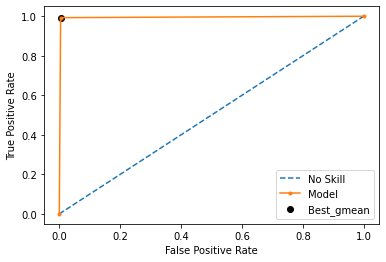

In [38]:
fpr, tpr, thresholds = roc_curve(np.append(y_train, y_test), np.append(preds_train, preds_test), pos_label=1)
gmeans = np.sqrt(tpr * (1-fpr)) #średnie geometryczne wyznaczone dla każdego punktu na krzywej ROC
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix])) #G-Mean - największa średnia geometryczna
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best_gmean')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [39]:
def get_threshold(y_train, y_test, train_preds, test_preds):
    y = np.append(y_train, y_test)
    preds = np.append(train_preds, test_preds)
    fpr, tpr, thresholds = roc_curve(y, preds)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f' % thresholds[ix])
    return thresholds[ix]

In [40]:
threshold_gmean = get_threshold(y_train, y_test, preds_train, preds_test)

Best Threshold=1.000000


W tym przypadku regresja logistyczna zwróciła predykcje dyskretne, będące równocześnie przyporządkowaniem do klas (co nie zdaża się zbyt często). Wartość wyznaczonego progu wynosi 1, czyli wszystkie predykcje <1 oznaczają klase 0, a predykcja = 1 oznacza klasę 1.

W kolejnym przykładzie lepiej będzie widać, po co wyznacza się progi i jak zazwyczaj wyglądają predykcje zwaracane przez regresory.

Teraz przeprowadzimy podobną analizę przy użyciu klasyfikatora opartego o maszynę wektorów nośnych (ang. support vector machine, SVM). SVM umożliwia klasyfikację również wtedy, gdy dane nie są liniowo separowalne. Wykorzystywana jest do tego tzw. funkcja jądra (ang. kernel), dzięki której dokonywane jest mapowanie danych na przestrzeń o wymiarze o jeden większym, gdzie już są (lub przynajmniej powinny być) liniowo separowalne. Co więcej, SVM dąży nie  tylko do rozdzielenia danych należących do różnych klas, ale też zrobienia tego z możliwie dużym marginesem zaufania. O tym, jak wysoka jest kara, która jest następstwem złej klasyfikacji obiektu oraz jak duży jest margines informuje parametr C (im mniejsze C tym bardziej uogólniony
model i większy margines).


Ponieważ chcemy wyznaczyć krzywą ROC i ROC AUC, zamiast predict użyjemy predict_proba, które zwróci prawdopodobieństwo przynależności do klas.

In [41]:
SVM = SVC(C=1.0, random_state=42, probability=True) #probability=True pozwala potem użyć metody predict_proba
SVM.fit(X_train, y_train)
SVM_test_preds = SVM.predict_proba(X_test)
SVM_train_preds = SVM.predict_proba(X_train)
print('test ROC AUC: ', roc_auc_score(y_test, SVM_test_preds[:,1])) 
#predict_proba zwraca macierz z prawdopodobieństwiem przynależności do każdej analizowanej klasy
#nas interesuje klasa 1, więc bierzemy kolumnę 1, w której są odpowiednie prawdopodobieństwa

test ROC AUC:  0.9467980295566503


Best Threshold=0.115326


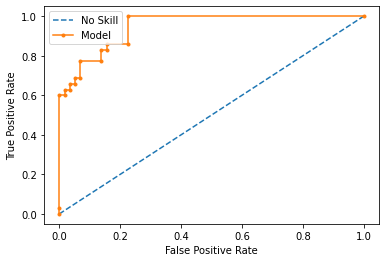

In [42]:
plot_roc_curve(y_test, SVM_test_preds[:,1], image_path=None)
threshold_gmean = get_threshold(y_train, y_test, SVM_train_preds[:,1], SVM_test_preds[:,1])

In [43]:
print(SVM_test_preds[:,1])

[0.8673091  0.08990218 0.89986073 0.08833518 0.12792291 0.2729154
 0.47381646 0.88768739 0.90491228 0.67377971 0.09009891 0.22120201
 0.55688546 0.06750794 0.08270912 0.09157163 0.89782078 0.0914677
 0.69011796 0.88798979 0.15002751 0.09405814 0.89247204 0.8782327
 0.09303848 0.8854262  0.099784   0.27284703 0.29588884 0.89355479
 0.88792922 0.37085513 0.08847481 0.88295772 0.09957648 0.87862114
 0.1075019  0.86626536 0.08679635 0.08486245 0.10497561 0.89506888
 0.86286669 0.13159311 0.09014849 0.57481102 0.07489649 0.08439307
 0.08982333 0.09075878 0.08681443 0.86994568 0.66545788 0.07592157
 0.08246977 0.902936   0.65796985 0.08930096 0.89148639 0.08448337
 0.0897108  0.12032434 0.08091179 0.08206696 0.29414722 0.88817915
 0.09872036 0.68661184 0.081904   0.73828659 0.08962644 0.89385266
 0.07755343 0.80436056 0.08036457 0.08376307 0.75226672 0.07820908
 0.88628188 0.88400883 0.12232487 0.88495377 0.09975117 0.87122877
 0.09441307 0.09374822 0.85453526 0.06914251 0.28503296 0.0861884

Jak widać, tym razem otrzymaliśmy wartości, które nie są dyskretne i nie da się na ich podstawie od razu stwierdzić, do której klasy mogą przynależeć analizowane obiekty. Dlatego trzeba odpowiednio przeliczyć je na klasy korzystając z wyznaczonej wartości progu. Uzyskane w ten sposób wyniki można wykorzystać np. do narysowania macierzy pomyłek.

In [44]:
boolean_SVM_test_preds = SVM_test_preds[:,1] > threshold_gmean
print(confusion_matrix(y_test, boolean_SVM_test_preds))
print(accuracy_score(y_test, boolean_SVM_test_preds))

[[44 14]
 [ 0 35]]
0.8494623655913979


Zobacz, jak wyniki będą zmieniać się w zależności od dobranego progu - wybierz kilka losowych wartości z przedziału [0,1] i wyznacz macierze pomyłek lub wybraną metrykę, np. dokładność (accuracy) lub czułość (recall).

In [45]:
boolean_SVM_test_preds = SVM_test_preds[:,1] > threshold_gmean
print(confusion_matrix(y_test, boolean_SVM_test_preds))
print(accuracy_score(y_test, boolean_SVM_test_preds))

[[44 14]
 [ 0 35]]
0.8494623655913979


Porównaj wyniki uzyskane przez progowanie wartości prawdopodobieństwa z tymi, które uzyskuje się prowadząc klasyfikację metodą predict. Czy są takie same?

In [46]:
SVM_test_preds2 = SVM.predict(X_test)
print(confusion_matrix(y_test, SVM_test_preds2))
print(accuracy_score(y_test, SVM_test_preds2))

[[50  8]
 [ 6 29]]
0.8494623655913979


Do tej pory preprocessing, np. standaryzację danych wykonywaliśmy przed tworzeniem i uczeniem modelu. Takie podejście może jednak prowadzić do błędów i niedopatrzeń - jeżeli będziemy chcieli w przyszłości wykorzystać zapisany model trzeba będzie pamiętać o takim samym przygotowaniu danych. Np. powyżej nie ustandaryzowaliśmy danych, co może negatywnie wpływać na uzyskane wyniki.

Zamiast osobnego przetwarzania danych można utworzyć tzw. pipeline. W pipeline'ie zapisany jest nie tylko sam model, ale też inne elementy, w tym właśnie przetwarzanie danych lub redukcja wymiarowości. Do pipeline'u podajemy nieprzetworzone dane, a preprocessing następuje automatycznie w taki sposób, jak został zadeklarowany na etapie przygotowania modelu.

In [47]:
#tworzymy pipeline, który składa się z StandardScalera, który standaryzuje dane oraz modelu SVC
SVM = make_pipeline(StandardScaler(), SVC(C=1.0, random_state=42, probability=True))
SVM.fit(X_train, y_train) #uczenie modelu
SVM_test_preds = SVM.predict_proba(X_test)
SVM_train_preds = SVM.predict_proba(X_train)
print('test ROC AUC: ', roc_auc_score(y_test, SVM_test_preds[:,1]))

test ROC AUC:  0.9921182266009851


Best Threshold=0.334563


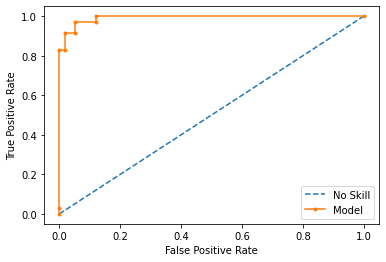

In [48]:
plot_roc_curve(y_test, SVM_test_preds[:,1], image_path=None)
threshold_gmean = get_threshold(y_train, y_test, SVM_train_preds[:,1], SVM_test_preds[:,1])

Dotychczas wszystkie modele tworzyliśmy w taki sposób, że samodzielnie dobieraliśmy wartości hiperparametrów. Zazwyczaj było to robione w sposób losowy.

W praktyce powinno się dobierać wartości hiperparametrów na drodze optymalizacji. Poniżej przykład jak zrobić to przy użyciu pakietu Optuna.

Najpierw należy zdefiniować, jaka metryka będzie służyła do oceny tego, który model (z jakimi hiperparametrami) jest lepszy. W przypadku modeli regresyjnych używanych do klasyfikacji jest zazwyczaj to ROC AUC lub log loss (w przypadku regresorów dopasowywanych do danych ciągłych najczęściej jest to MSE - mean squared error lub MAE - mean absolute error, patrz zad. 3). My będziemy wykorzystywać ROC AUC.

In [49]:
scoring = {'roc_macro': make_scorer(roc_auc_score, average='macro')}

Następnie należy zdefiniować objective, czyli funkcję celu. Do niej podawany jest model, liczba prób wykonywana podczas całego procesu optymalizacji (losowań wartości hiperparametrów), hiperparametry, które będą optymalizowane oraz dane uczące.

In [50]:
def objective(trial, model, get_space, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5), return_train_score=True)

    return np.mean(scores['test_roc_macro'])

W powyższej funkcji celu korzystamy z walidacji krzyżowej (cross-validation). Do tej pory wykonywaliśmy walidację prostą - dane były dzielone na zbiór uczący i testowy, a model ocenialiśmy tylko na podstawie metryk wyliczonych dla zbioru testowego.

Walidacja krzyżowa jest alternatywnym podejściem do oceny modelu. Dane, które wykorzystywane są w procesie uczenia dzielone są na k podzbiorów (tzw. foldów) i uczenie przebiega w nastepujący sposób:

1. k-1 podzbiorów tworzy zbiór uczący, na którym uczony jest model, a ostatni pozbiór służy do walidacji (czyli przeprowadzenia predykcji i wyznaczenia metryk),
    
2. proces powtarzany jest k-krotnie tak, by każdy z podzbiorów był użyty do walidacji,
    
3. wyniki ze wszystkich k predykcji są uśredniane,
    
4. można wyliczyć też odchylenie standardowe wyników uzyskanych na wszystkich foldach - wtedy mamy informację, czy model zawsze daje zbliżone wyniki, czy też zdarzyło się, że na którymś foldzie dał dużo niższe niż na innych (nie jest to pożądane).

Korzystamy z funkcji StratifiedKFold, która przy okazji zapewnia stratyfikację danych podczas dzielenia na podzbiory.

Często można spotkać się z tym, że do walidacji krzyżowej użyte są całe posiadane dane (nie wyodrębnia się zbioru testowego). Takie podejście nie jest polecane, ponieważ nie daje pełnego oglądu możliwości modelu. Najbardziej rekomendowane jest prowadzenie walidacji krzyżowej z wykorzystaniem zbioru uczącego, a następnie przeprowadzenie dodatkowej oceny modelu z użyciem zbioru testowego - tak będziemy robić na zajęciach.

Kolejną rzeczą, którą należy określić przed dokonaniem optymalizacji, są hiperparametry, które będą optymalizowane oraz zakresy wartości, które będą mogły przyjąć. Na razie będziemy wykorzystywać trzy rodzaje hiperparametrów:

1. przyjmujące tylko wartości całkowite, np. liczba iteracji, liczba sąsiadów w metodzie kNN - do zdefiniowania możliwych wartości należy użyć metody suggest_int,
    
2. przyjmujące wartości kategorialne, np. rodzaj jądra (kernel) - do zdefiniowania możliwych wartości należy użyć metody suggest_categorical,
    
3. przyjmujące wartości rzeczywiste, często z przedziału [0,1] - do zdefiniowania możliwych wartości należy użyć metody suggest_uniform.
    
Dodatkowo definiujemy model, którego chcemy użyć (w tym przypadku regresja logistyczna) oraz liczbę prób (triali), które będą wykonane w celu ustalenia najlepszych hiperparametrów. Na razie dajemy małą liczbę prób, żeby nie tracić  zbyt dużo czasu - niestety optymalizacja jest bardzo czasochłonna, a na zajęciach nie mamy tyle czasu. W przypadku bardziej skomplikowanych modeli o dużej liczbie hiperparametrów, liczba triali musi być zdecydowanie większa niż 5, żeby uzyskać satysfakcjonujące wyniki - może wynosić nawet kilka tysięcy, np. w przypadku lasów losowych czy innych algorytmów drzewiastych.

In [51]:
model = LogisticRegression
def get_space(trial): 
    space = {"C": trial.suggest_uniform("C", 0, 1), 
           'max_iter': trial.suggest_int('max_iter', 100, 100),
           "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear"])}
    return space
trials = 5 #liczba prób

Powyższe trzy hiperparametry to:
1. C - określa regularyzację, czyli ograniczenie wartości współczynników (wag) tego modelu, co pozwala zmniejszyc ryzyko przeuczenia modelu i nadmiernego dopasowania do danych. Podobnie jak w SVM, im mniejsze C, tym większe zdolność modelu do generaliacji.
2. solver - algorytm wykorzystywany do optymalizacji wag, 
3. max_iter - maksymalna liczba iteracji (prób), które będą wykonane, by solver osiągnął warunek zatrzymania (możliwe pod warunkiem, że solver jest zbieżny).

Gdy mamy już wszystko zdefiniowane, możemy w końcu przejść do optymalizacji. Określamy jeszcze, czy metryka stosowana przez nas ma być maksymalizowana czy minimalizowana - chcemy mieć jak największy ROC AUC, więc wybieramy direction='maximize' i rozpoczynamy optymalizację.

In [52]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda x: objective(x, model, get_space, X_train_scaled, y_train), n_trials=trials)

[I 2022-12-19 20:52:50,777] A new study created in memory with name: no-name-0d5fc551-fc9d-4db6-8c56-53f94e206101
C:\Users\jakub\AppData\Local\Temp\ipykernel_1868\831137447.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),
[I 2022-12-19 20:52:54,251] Trial 0 finished with value: 0.9515609880315763 and parameters: {'C': 0.2727377542745062, 'max_iter': 100, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9515609880315763.
C:\Users\jakub\AppData\Local\Temp\ipykernel_1868\831137447.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),
[I 2022-12-19 20:52:58,

Gdy model jest już zoptymalizowany, możemy wyświetlić wartości hiperparametrów, które zostały dobrane.

In [53]:
print('params: ', study.best_params)

params:  {'C': 0.6555514217590153, 'max_iter': 100, 'solver': 'lbfgs'}


Następnie uczymy model o dobranych hiperparametrach i prowadzimy predykcję, żeby zobaczyć, czy faktycznie uzyskujemy dobre wyniki.

In [54]:
lr = model(**study.best_params)
lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)
pickle.dump(lr, open('lr_model', 'wb+'))
print('test ROC_AUC: ', roc_auc_score(y_test, preds))

test ROC_AUC:  0.9770935960591133


Porównaj uzyskaną wartość ROC AUC z tą, którą uzyskaliśmy samodzielnie dobierając wartości hiperparametrów. Możesz spróbowac zwiększyć liczbę triali, jeżeli wyniki nie są satysfakcjonujące.

W analogiczny sposób zoptymalizuj SVC - optymalizacji poddaj 3 hiperparametry: C, kernel i degree. W tym celu przeanalizuj najpierw dokumentację funkcji i to, jakie wartości mogą przyjmować te parametry: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

C i kernel były wyjaśnione wcześniej. Degree określa stopień wielomianu funkcji jądra, jeżeli kernel='poly'. W przypadku innych funkcji jądra jest ignorowany.

In [55]:
def get_space1(trial): 
    space = {"C": trial.suggest_uniform("C", 0, 1), 
           "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
            'degree': trial.suggest_int('degree', 1,3)}
    return space

def objective(trial, model, get_space, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5), return_train_score=True)

    return np.mean(scores['test_roc_macro'])
model = SVC
trials = 5
study = optuna.create_study(direction='maximize')
study.optimize(lambda x: objective(x, model, get_space1, X_train_scaled, y_train), n_trials=trials)

[I 2022-12-19 20:53:19,063] A new study created in memory with name: no-name-11fe6a5e-b971-4e3f-ab9c-74a2e2d77df9
C:\Users\jakub\AppData\Local\Temp\ipykernel_1868\2330379732.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),
[I 2022-12-19 20:53:56,065] Trial 0 finished with value: 0.940348866819455 and parameters: {'C': 0.6591723290564738, 'kernel': 'rbf', 'degree': 2}. Best is trial 0 with value: 0.940348866819455.
C:\Users\jakub\AppData\Local\Temp\ipykernel_1868\2330379732.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),
[I 2022-12-19 20:54:14,147] T

In [56]:
print('params: ', study.best_params)
lr = model(**study.best_params)
lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)
pickle.dump(lr, open('lr_model', 'wb+'))
print('test ROC_AUC: ', roc_auc_score(y_test, preds))

params:  {'C': 0.20706206095951896, 'kernel': 'linear', 'degree': 3}
test ROC_AUC:  0.9770935960591133
